<a href="https://colab.research.google.com/github/jsebastianquiroga/analitica_ia_puj/blob/main/DL/NYU_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes convolucionales:

Codigo de https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb 

Para obtener buenos resultados, necesitamos incorporar cierto conocimiento previo sobre el problema.

Las suposiciones nos ayudan cuando son verdaderas.
Nos perjudican cuando no lo son.
Queremos hacer solo la cantidad justa de suposiciones, no más que eso.
En Aprendizaje Profundo
Muchas capas: composicionalidad
Convoluciones: localidad + estacionariedad de imágenes
Pooling: invarianza de clase de objeto a traducciones.

# Set up

In [81]:
!wget https://raw.githubusercontent.com/jsebastianquiroga/analitica_ia_puj/main/DL/res/plot_lib.py
from plot_lib import plot_data, plot_model, set_default

set_default()


--2023-05-07 06:06:57--  https://raw.githubusercontent.com/jsebastianquiroga/analitica_ia_puj/main/DL/res/plot_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4400 (4.3K) [text/plain]
Saving to: ‘plot_lib.py.1’

plot_lib.py.1       100%[===================>]   4.30K  --.-KB/s    in 0s      

2023-05-07 06:06:58 (34.8 MB/s) - ‘plot_lib.py.1’ saved [4400/4400]



In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [84]:
device

device(type='cpu')

# Cargar el conjunto de datos (MNIST)

Podemos usar algunas utilidades DataLoader de PyTorch para esto. Esto descargará, mezclará, normalizará los datos y los organizará en lotes.

In [85]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes
n_epochs = 5

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

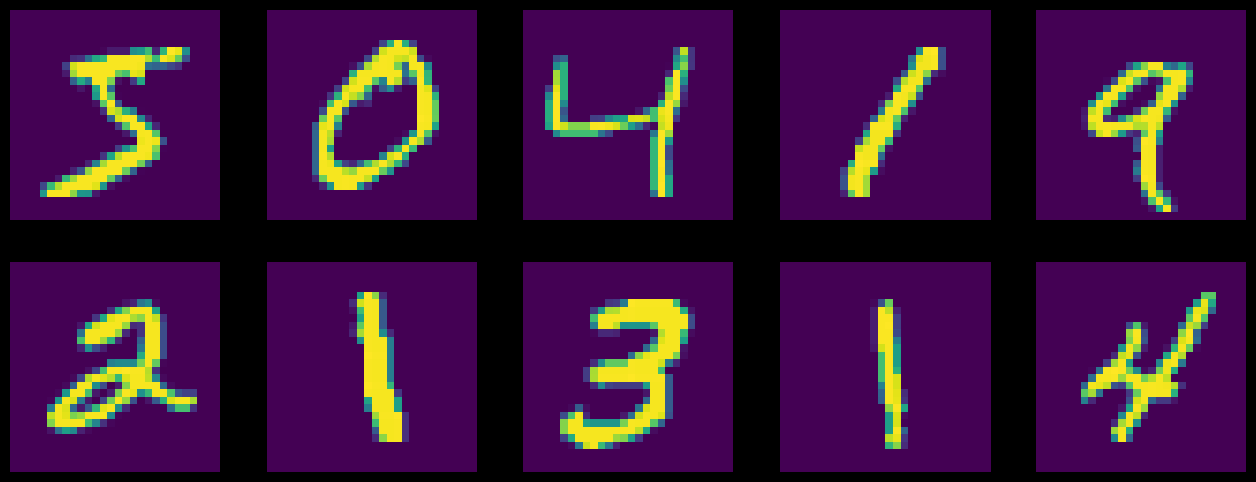

In [86]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Creacion de modelo:

La clase FC2Layer es una red neuronal con dos capas ocultas completamente conectadas. La primera capa tiene n_hidden neuronas y la segunda capa oculta también tiene n_hidden neuronas. La última capa es una capa completamente conectada con output_size neuronas. La función de activación ReLU se utiliza en

In [87]:
import torch.nn as nn
import torch.nn.functional as F

class FC2Layer(nn.Module): #Fully-conected 2 layer
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__() # llama al método __init__() de la superclase nn.Module, lo que permite inicializar la clase FC2Layer con todas las características de la superclase.
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),  # Capa completamente conectada con n_hidden neuronas
            nn.ReLU(),                       # Función de activación ReLU
            nn.Linear(n_hidden, n_hidden),   # Capa completamente conectada con n_hidden neuronas
            nn.ReLU(),                       # Función de activación ReLU
            nn.Linear(n_hidden, output_size),# Capa completamente conectada con output_size neuronas
            nn.LogSoftmax(dim=1)             # Función de activación LogSoftmax en la última capa
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)     # Redimensionamos la entrada para que sea un tensor de (batch_size, input_size)
        return self.network(x)             # Devolvemos la salida de la red neuronal

class CNN(nn.Module): #convolutional net
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)  # Capa convolucional con n_feature filtros de 5x5
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)                 # Capa convolucional con n_feature filtros de 5x5
        self.fc1 = nn.Linear(n_feature*4*4, 50)                                    # Capa completamente conectada con 50 neuronas
        self.fc2 = nn.Linear(50, output_size)                                       # Capa completamente conectada con output_size neuronas
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)       # Capa convolucional 1
        x = F.relu(x)           # Función de activación ReLU
        x = F.max_pool2d(x, kernel_size=2)   # Capa de pooling
        x = self.conv2(x)       # Capa convolucional 2
        x = F.relu(x)           # Función de activación ReLU
        x = F.max_pool2d(x, kernel_size=2)   # Capa de pooling
        x = x.view(-1, self.n_feature*4*4)   # Redimensionamos la entrada para que sea un tensor de (batch_size, n_feature*4*4)
        x = self.fc1(x)         # Capa completamente conectada
        x = F.relu(x)           # Función de activación ReLU
        x = self.fc2(x)         # Capa completamente conectada
        x = F.log_softmax(x, dim=1)          # Función de activación LogSoftmax en la última capa
        return x


## Running on a GPU: device string

La alternancia entre CPU y GPU en PyTorch se controla a través de una cadena de dispositivo, que determinará sin problemas si la GPU está disponible, y en caso contrario, utilizará la CPU como respaldo.

In [88]:
accuracy_list = []  # Lista que guardará la precisión del modelo en cada iteración

# Función para entrenar el modelo
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()  # Modo entrenamiento
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)  # Envía los datos y etiquetas al dispositivo (CPU/GPU)

        # permute pixels
        data = data.view(-1, 28*28)  # Redimensiona la entrada a un vector de una dimensión
        data = data[:, perm]  # Permuta los píxeles según el índice especificado
        data = data.view(-1, 1, 28, 28)  # Redimensiona la entrada para que sea un tensor de 4 dimensiones (batch_size, canales, altura, anchura)

        optimizer.zero_grad()  # Reinicia los gradientes a cero
        output = model(data)  # Obtiene las predicciones del modelo
        loss = F.nll_loss(output, target)  # Calcula la función de pérdida
        loss.backward()  # Calcula los gradientes
        optimizer.step()  # Actualiza los parámetros del modelo
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))  # Imprime la información del entrenamiento

# Función para evaluar el modelo
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()  # Modo evaluación
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)  # Envía los datos y etiquetas al dispositivo (CPU/GPU)

        # permute pixels
        data = data.view(-1, 28*28)  # Redimensiona la entrada a un vector de una dimensión
        data = data[:, perm]  # Permuta los píxeles según el índice especificado
        data = data.view(-1, 1, 28, 28)  # Redimensiona la entrada para que sea un tensor de 4 dimensiones (batch_size, canales, altura, anchura)
        output = model(data)  # Obtiene las predicciones del modelo
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # Suma la pérdida del batch actual
        pred = output.data.max(1, keepdim=True)[1]  # Obtiene la etiqueta predicha
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()  # Compara la etiqueta predicha con la etiqueta real

    test_loss /= len(test_loader.dataset)  # Calcula la pérdida promedio en todo el conjunto de pruebas
    accuracy = 100. * correct / len(test_loader.dataset)  # Calcula la precisión del modelo en el conjunto de pruebas
    accuracy_list.append(accuracy)  # Añade la precisión a la lista de precisión
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))


# 1. Modelo Fully conected

In [89]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306416
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.029317
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.482590
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.081869
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.928605
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.917301
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.633300
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.837645
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.415431
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.874895

Test set: Average loss: 0.4713, Accuracy: 8620/10000 (86%)



# Modelo 2: Conv con los mismos parametros

In [90]:
# Training settings 
n_features = 6 # number of feature maps
n_epochs = 5

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.317295
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.308812
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.409481
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.420288
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.266903
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.371592
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.309309
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.528220
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.212291
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.175792

Test set: Average loss: 0.2102, Accuracy: 9346/10000 (93%)



# La red convolucional funciona mejor con el mismo número de parámetros, gracias a su uso del conocimiento previo sobre imágenes
<ol>
<li>Uso de convolución: localidad y estacionariedad en las imágenes</li>
<li>Pooling: incorpora cierta invariancia a la traslación</ol></li>


#  ¿Qué sucede si las suposiciones ya no son ciertas?


Se cambia el orden y la estrucutra de los numeros

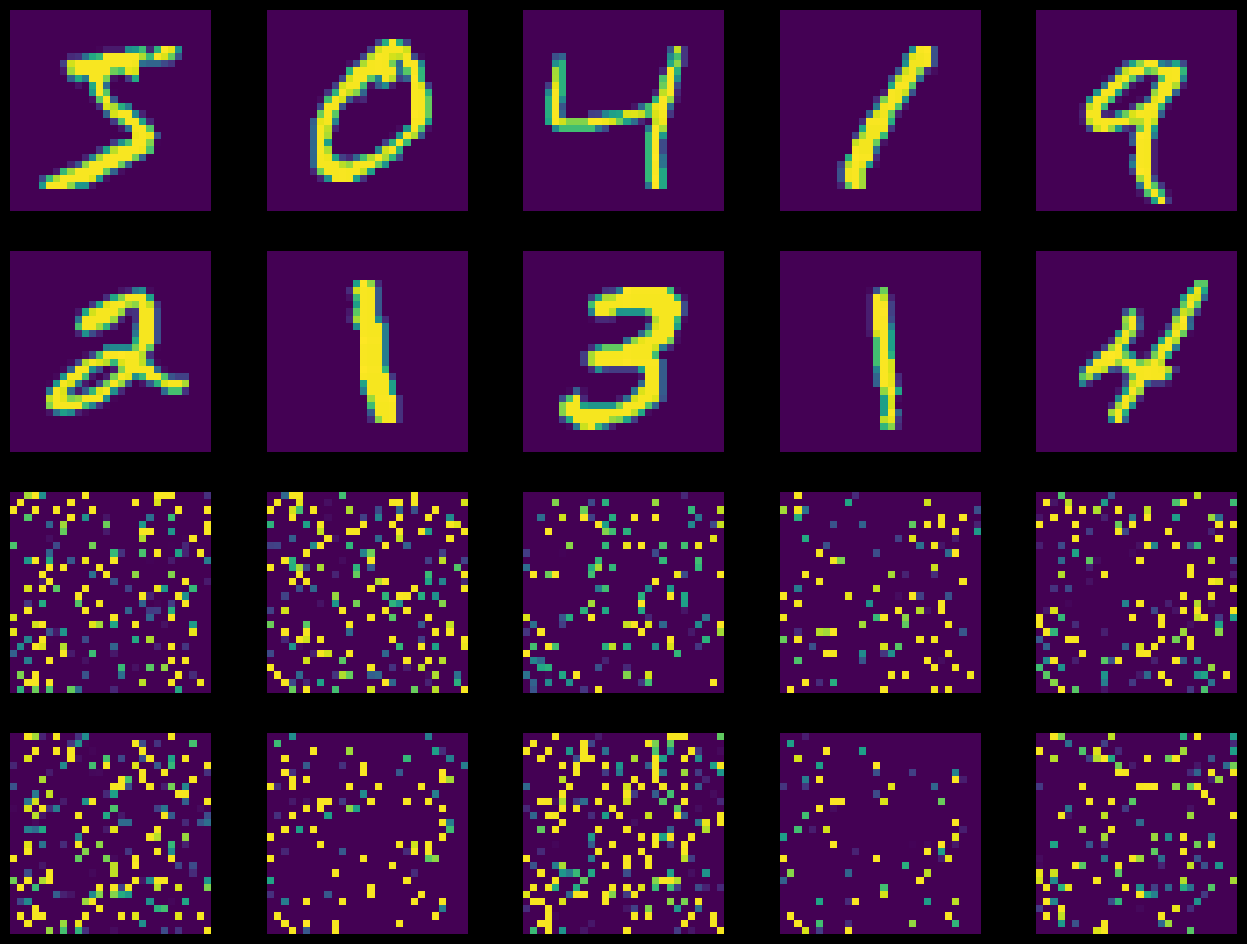

In [91]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet con los pixeles permutados.

El mismo modelo despues de la primera epoca:</br></br> Test set: Average loss: 0.1985, Accuracy: 9380/10000 (94%)

In [92]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313613
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.254158
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.138839
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.779968
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.413561
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.065103
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.876986
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.646251
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.727600
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.653465

Test set: Average loss: 0.6222, Accuracy: 8075/10000 (81%)



Su rendimiento bajo, al romper la estrucutra y patrones de la matriz

# Fully-Connected pixeles permutados: 

El previo modelo tenia: </br></br>Test set: Average loss: 0.4285, Accuracy: 8703/10000 (87%)

In [93]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.337122
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.640466
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.363870
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.622338
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.658947
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.032251
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.296694
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.483210
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.258298
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.332208

Test set: Average loss: 0.4468, Accuracy: 8690/10000 (87%)



# La performance de la red convolucional disminuye cuando permutamos los píxeles, pero la performance de la red completamente conectada se mantiene igual.

La red convolucional hace la suposición de que los píxeles están en una cuadrícula y son estacionarios/locales.
Pierde rendimiento cuando esta suposición es incorrecta.
La red completamente conectada no hace esta suposición.
Funciona menos bien cuando esta suposición es cierta, ya que no aprovecha este conocimiento previo.
Pero no sufre cuando la suposición es incorrecta.

<ipython-input-94-9003589eb26e>:8: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


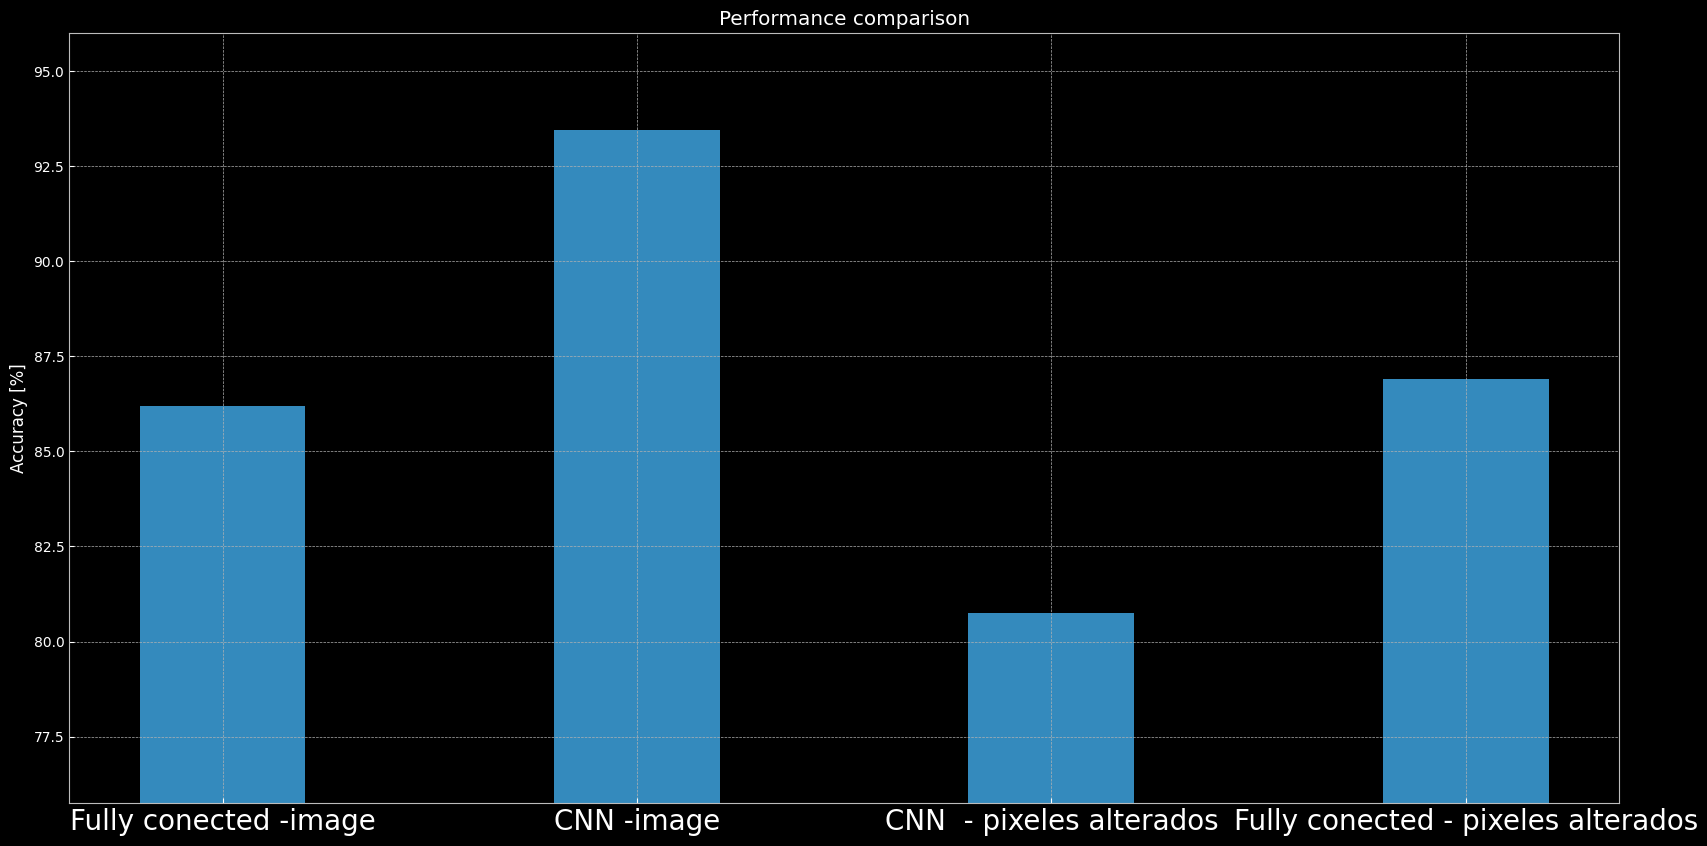

In [94]:
plt.figure(figsize=(20, 10))
plt.bar(('Fully conected -image', 'CNN -image',
         'CNN  - pixeles alterados', 'Fully conected - pixeles alterados'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

In [95]:
print(dir(model_cnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save

In [96]:
print(dir(model_fnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save